In [4]:
import numpy as np
import netCDF4 as nc
import h5py
import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
import seaborn as sns
import matplotlib as mpl
import cv2
from datetime import datetime

from tensorflow.keras.models import load_model, Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Input, Concatenate

# this way I do not have to reshape the data
from keras.backend import set_image_data_format, image_data_format
from tensorflow.compat.v1 import disable_eager_execution
from tensorflow import executing_eagerly
from tensorflow.python.compiler.mlcompute import mlcompute

# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

set_image_data_format('channels_first')
assert image_data_format() == 'channels_first', "Plase set keras backend as channels first."

# APPLE SPECIFIC IMPLEMENTATION
disable_eager_execution()
assert executing_eagerly() is False, "Please do not set to eager execution for this program."

# Import mlcompute module to use the optional set_mlc_device API for device selection with ML Compute.
mlcompute.set_mlc_device(device_name='cpu')  # Available options are 'cpu', 'gpu', and 'any'.

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

In [5]:
HOW_MANY = 3

# FAKE DATA
print("Load fake data")
datapath = './data.nosync/b.e11.B20TRC5CNBDRD.f09_g16.002.cam.h1.U850.19200101-20051231.nc'
dataset = nc.Dataset(datapath)

U850_period_interest = dataset['U850'][(dataset['date'][:] > 20041231)
                                       & (dataset['date'][:] < 20060101)]

lon_model = dataset['lon'][:]
lat_model = dataset['lat'][:]

# REAL DATA
print("Load real data")
hf = h5py.File("./data.nosync/georeferenced_pos.h5", 'r')

print('Prepare fake dates')
date_period_interest = dataset['date'][(dataset['date'][:] > 20041231)
                                       & (dataset['date'][:] < 20060101)]

date_fake = [
    datetime.strptime(str(date), "%Y%m%d").date()
    for date in date_period_interest
]

print("Prepare real dates")
date_real = hf['time'][()].astype("<M8[us]")
date_real = [date.astype(datetime).date() for date in date_real]

print("Select %i random real cyclons." % HOW_MANY)
idx_cyclons = sorted(
    np.random.uniform(0, len(date_real), HOW_MANY).astype(int))

Load fake data
Load real data
Prepare fake dates
Prepare real dates
Select 3 random real cyclons.


In [6]:
real_images = hf['images'][idx_cyclons]
date_real = np.array(date_real)[idx_cyclons]
print("Find corresponding fake image.")
idx_fake_cyclon = [
    np.where(np.array(date_fake) == dd)[0][0] for dd in date_real
]
fake_images = U850_period_interest[idx_fake_cyclon]

print("Cut around cyclon in fake images")
fake_images = [
    fake_image[np.where(np.isclose(lon_model, lon_min, 0.5))[0][0]:np.
               where(np.isclose(lon_model, lon_max, 0.5))[0][0],
               np.where(np.isclose(lat_model, lat_min, 0.5))[0][0]:np.
               where(np.isclose(lat_model, lat_max, 0.5))[0][0]]
    for fake_image, lat_min, lat_max, lon_min, lon_max in zip(
        fake_images, hf['lat_min'][idx_cyclons], hf['lat_max'][idx_cyclons],
        hf['lon_min'][idx_cyclons], hf['lon_max'][idx_cyclons])
]

# i dati sono già ordina
print('Resize to correct size')
fake_images = [
    cv2.resize(np.transpose(fake_image),
               dsize=(120, 120),
               interpolation=cv2.INTER_CUBIC) for fake_image in fake_images
]
fake_images = np.stack(fake_images, axis=0)

print('Consider only U850 channel in real images')
real_images = real_images[:,[0],:,:]

fake_images = np.expand_dims(fake_images, axis = 1)

assert fake_images.shape == real_images.shape, 'Some mistake in the definition of the arrays'

Find corresponding fake image.
Cut around cyclon in fake images
Resize to correct size
Consider only U850 channel in real images


In [7]:
print("Loading VGG (with concatenation of the single channel)")
new_input = Input(shape=fake_images.shape[1:])
img_conc = Concatenate(axis = 1)([new_input, new_input, new_input])  
VGG_model = VGG16(include_top=False, input_tensor=img_conc)
base_model = Model(inputs = VGG_model.input, outputs = VGG_model.layers[15].output)

print("Load pre-trained CNN classifier for cyclons (U850 specific)")
U850_model = load_model("./model_just_850")

print(
    "Since the real data depicts all cyclons, we are sure the correct class to be '1'."
)
print("Let's see a (very) bias accuracy")
print("ACC: %.3f" % (U850_model.evaluate(base_model.predict(real_images),
                                         np.zeros(len(real_images)) + 1)[-1]))

Loading VGG (with concatenation of the single channel)
Load pre-trained CNN classifier for cyclons (U850 specific)
Since the real data depicts all cyclons, we are sure the correct class to be '1'.
Let's see a (very) bias accuracy


/Users/leonardoalchieri/anaconda3/envs/tf_apple_2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


ACC: 1.000


In [8]:
print("Let's select the cyclons the classifier manages to classify correctly.")
correct_idx = np.where(
    (U850_model.predict(base_model.predict(real_images)) + 0.5).astype(int) == 1)[0]

Let's select the cyclons the classifier manages to classify correctly.


In [9]:
print("Accuracy on fake data %.3f" %(U850_model.evaluate(base_model.predict(fake_images[correct_idx]),
                    np.zeros(len(correct_idx)) + 1)[-1]))

Accuracy on fake data 0.000


In [10]:
print(
    """[COMMENT] The low accuracy score 
        on the fake images can mostly 
        be due to the incapacity of 
        the generative model, and 
        not my classifier, which on 
        real data predict correctly 
        the presence of a cyclon in 
        the same region."""
)

[COMMENT] The low accuracy score 
        on the fake images can mostly 
        be due to the incapacity of 
        the generative model, and 
        not my classifier, which on 
        real data predict correctly 
        the presence of a cyclon in 
        the same region.


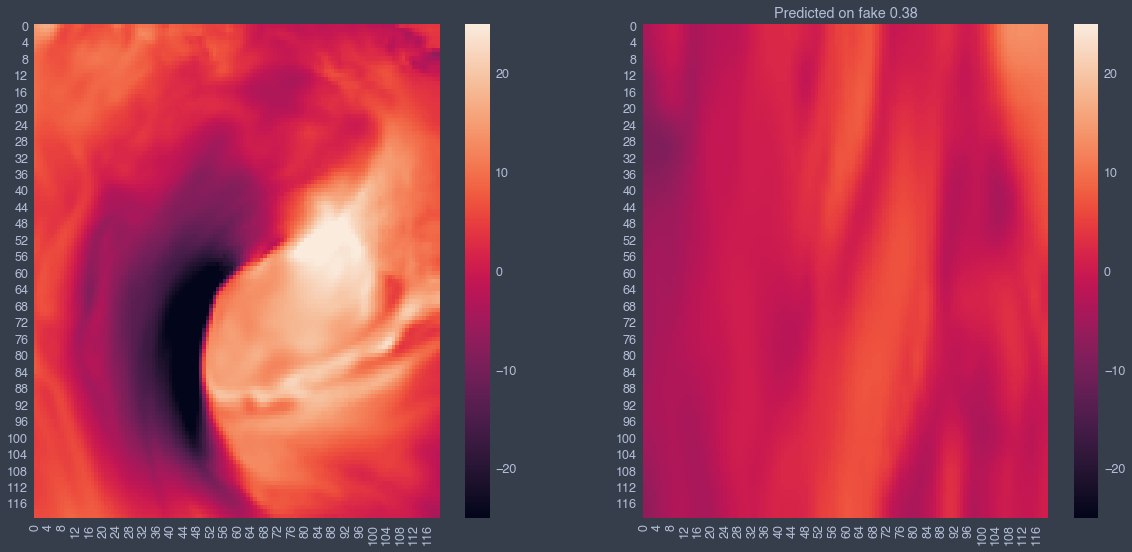

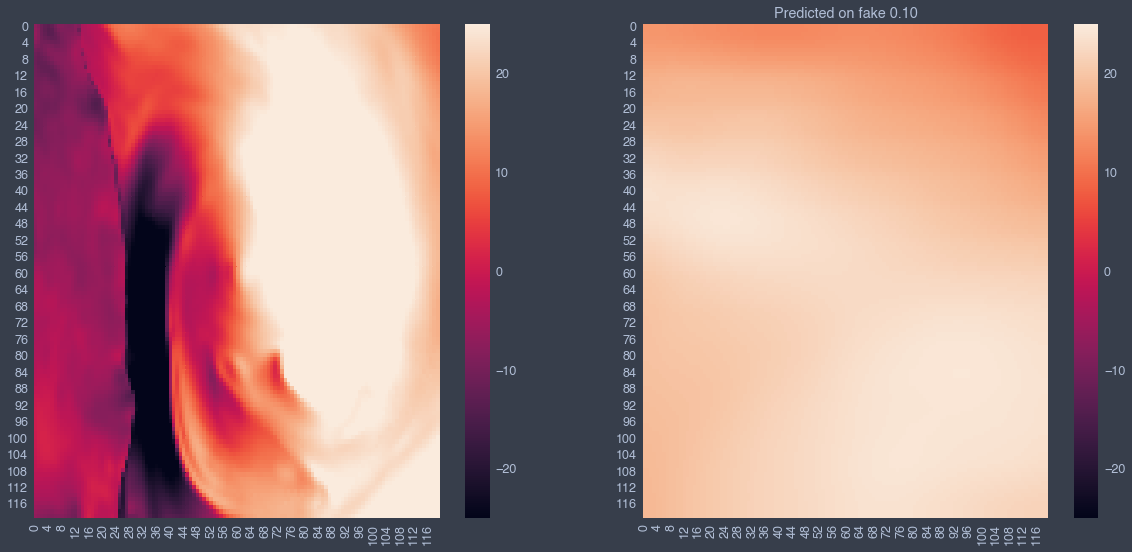

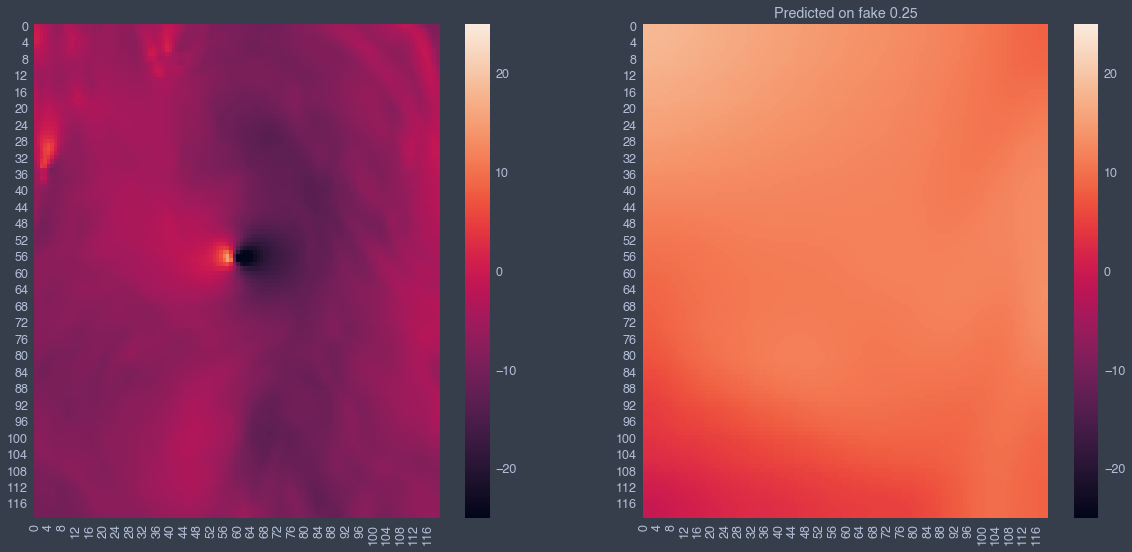

In [11]:
for idx in correct_idx:
    plt.figure(figsize=(20, 20))
    plt.subplot(221)
    sns.heatmap(np.transpose(real_images[idx, 0, :, :]), vmin=-25, vmax=25)

    plt.subplot(222)
    sns.heatmap(np.transpose(fake_images[idx, 0, :, :]), vmin=-25, vmax=25)
    plt.title(
        "Predicted on fake %.2f" %
        (U850_model.predict(base_model.predict(fake_images[[idx], :, :, :]))))
    plt.show()